In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import glob
from tqdm import tqdm
import itertools
import pickle
from scipy.spatial.transform import Rotation

In [2]:
with open("/media/ob1/drive1/data/smartwatch/subjects_2023-07-05/valid_files.txt") as f:
    valid_files = f.readlines()
    valid_files = [x.strip() for x in valid_files]

# Get IMU start-end times

In [3]:
data_dir = "/media/ob1/drive1/data/smartwatch/subjects_2023-07-05/"
results = {}

for file in valid_files:
    df = pd.read_csv(data_dir + file + "_imu.csv")
    min_ts = df.loc[:, [" Sensor Type", "Sample Time [s]"]].groupby(by=" Sensor Type").min().values
    max_ts = df.loc[:, [" Sensor Type", "Sample Time [s]"]].groupby(by=" Sensor Type").max().values
    results.setdefault("file", []).append(file)
    results.setdefault("start", []).append(np.max(min_ts))
    results.setdefault("end", []).append(np.min(max_ts))

In [4]:
df_start_end = pd.DataFrame(results)
df_start_end

,file,start,end
0,S01/S01_E1_R_1,0.328729,27.966833
1,S01/S01_E1_R_2,0.428081,22.987669
2,S01/S01_E2_R_1,0.270008,40.147617
3,S01/S01_E2_R_2,0.241172,42.012245
4,S01/S01_E3_R_1,0.207880,50.143430
...,...,...,...
1206,S82B/S82B_E7_R_2,0.243270,64.718110
1207,S82B/S82B_E8_R_1,0.243270,49.098522
1208,S82B/S82B_E8_R_2,0.041943,46.959427
1209,S82B/S82B_E9_R_1,0.050332,84.934654


In [5]:
df_start_end.to_csv("/media/ob1/drive1/data/smartwatch/analysis/imu_valid_times_2023-07-05.csv", index=False)

## Combine the IMU and MOCAP valid times

In [6]:
df_mocap_ts = pd.read_csv("/media/ob1/drive1/data/smartwatch/analysis/mocap_valid_times_2023-07-05.csv", names=["file", "mocap_start", "mocap_end"], header=0)
df_imu_ts = pd.read_csv("/media/ob1/drive1/data/smartwatch/analysis/imu_valid_times_2023-07-05.csv", names=["file", "imu_start", "imu_end"], header=0)

In [7]:
df_ts = pd.merge(df_mocap_ts, df_imu_ts)

In [8]:
df_ts

,file,mocap_start,mocap_end,imu_start,imu_end
0,S01/S01_E1_R_1,0.0,28.54,0.328729,27.966833
1,S01/S01_E1_R_2,0.0,23.02,0.428081,22.987669
2,S01/S01_E2_R_1,0.0,40.08,0.270008,40.147617
3,S01/S01_E2_R_2,0.0,41.08,0.241172,42.012245
4,S01/S01_E3_R_1,0.0,50.56,0.207880,50.143430
...,...,...,...,...,...
1195,S82B/S82B_E7_R_2,0.0,64.54,0.243270,64.718110
1196,S82B/S82B_E8_R_1,0.0,48.60,0.243270,49.098522
1197,S82B/S82B_E8_R_2,0.0,47.30,0.041943,46.959427
1198,S82B/S82B_E9_R_1,0.0,85.02,0.050332,84.934654


In [9]:
df_ts["start"] = np.max(df_ts[["mocap_start", "imu_start"]].values, axis=1)
df_ts["end"] = np.min(df_ts[["mocap_end", "imu_end"]].values, axis=1)

In [10]:
df_ts

,file,mocap_start,mocap_end,imu_start,imu_end,start,end
0,S01/S01_E1_R_1,0.0,28.54,0.328729,27.966833,0.328729,27.966833
1,S01/S01_E1_R_2,0.0,23.02,0.428081,22.987669,0.428081,22.987669
2,S01/S01_E2_R_1,0.0,40.08,0.270008,40.147617,0.270008,40.080000
3,S01/S01_E2_R_2,0.0,41.08,0.241172,42.012245,0.241172,41.080000
4,S01/S01_E3_R_1,0.0,50.56,0.207880,50.143430,0.207880,50.143430
...,...,...,...,...,...,...,...
1195,S82B/S82B_E7_R_2,0.0,64.54,0.243270,64.718110,0.243270,64.540000
1196,S82B/S82B_E8_R_1,0.0,48.60,0.243270,49.098522,0.243270,48.600000
1197,S82B/S82B_E8_R_2,0.0,47.30,0.041943,46.959427,0.041943,46.959427
1198,S82B/S82B_E9_R_1,0.0,85.02,0.050332,84.934654,0.050332,84.934654


- Realign timestamps
- Resample
- Process MOCAP
    - Remove NaNs
    - Convert to features
    - Normalize
- Process IMU
    - Combine features
    - Rename columns
    - Normalize

# Loading functions

In [11]:
def load_mocap_df(fp):
    # Read the header of the file to get columns and frequency info
    with open(fp, 'r') as f:
        old_line = ""
        new_line = ""
        frequency = None
        for skip_lines, new_line in enumerate(f):
            if len([x for x in old_line.split(",") if x]) > 5:
                break  # Stop when we encounter the first very long header row
            if old_line.lower().strip() == "trajectories":
                frequency = float(new_line.split(",")[0])  # Sometimes frequency has ",hz" on the same line
            old_line = new_line
    subject = fp.split("/")
    header = old_line.split(",")
    header_markers = [col.split(':')[-1] for col in header]
    # We need radial styloid (RS), ulnar styloid (US), medial epicondyle (ME), and lateral epicondyle (LE)
    # for computing forearm orientation and positions
    markers = ["R_RS", "R_US", "R_ME", "R_LE"]
    col_names = [f"{marker}_{axis}" for marker, axis in itertools.product(markers, "XYZ")]
    col_inds = []
    for marker in markers:
        i = header_markers.index(marker)
        col_inds.extend([i, i+1, i+2])  

    # Sort by names by index, pandas usecols arg uses sorted column order
    col_inds, col_names = list(zip(*sorted(zip(col_inds, col_names))))

    df = pd.read_csv(fp, skiprows=skip_lines + 2, usecols=col_inds, names=col_names)
    df.index = pd.to_timedelta(df.index / frequency, unit="seconds")
    df = df.resample("0.02S").mean()  # Resample to 50 Hz
    return df

In [12]:
def load_imu_dfs(fp):
    df = pd.read_csv(fp)
    df = df.rename(columns={" Sensor Type": "Sensor Type"})
    subdfs = []
    for sensor_type, sensor_name, decimals in zip([1, 2, 4], ["a_", "m_", "g_"], [2, 1, 3]):
        # Select data by sensor type
        subdf = df.loc[df["Sensor Type"] == sensor_type, :]
        # Conver index to timedeltas, same as the MOCAP
        subdf.index = subdf["Sample Time [s]"].values
        subdf.index = pd.to_timedelta(subdf.index, unit="seconds")
        # Deal with the columns
        subdf = subdf.drop(columns=["Sample Time [s]", "Sensor Type"])
        new_column_map = {f"val{i}": f"{sensor_name}{i}" for i in range(1, 4)}
        subdf = subdf.rename(columns=new_column_map)
        # Round for easier stats
        subdf = subdf.round(decimals)
        subdfs.append(subdf)
    return subdfs

In [13]:
imu_fp = data_dir + valid_files[0] + "_imu.csv"
dfs = load_imu_dfs(imu_fp)
dfs[0]

,a_1,a_2,a_3
0 days 00:00:00,8.77,-5.71,1.47
0 days 00:00:00.010223616,8.76,-5.95,1.73
0 days 00:00:00.020185089,8.79,-6.32,1.78
0 days 00:00:00.030408705,8.90,-6.44,1.64
0 days 00:00:00.040370177,9.05,-6.26,1.44
...,...,...,...
0 days 00:00:27.926462,13.85,-2.16,8.16
0 days 00:00:27.936686,13.53,-2.67,8.32
0 days 00:00:27.946648,13.36,-3.17,8.27
0 days 00:00:27.956871,13.41,-3.32,8.16


# Process functions

In [14]:
def process_mocap_df(df, force_positive=True):
    # Fill inner NaNs, edge NaNs dropped already by timestamp alignment
    df = df.interpolate(method="linear", axis=0, limit_area="inside")
    
    # Get marker positions
    p_rs = df.loc[:, ["R_RS_X", "R_RS_Y", "R_RS_Z"]].values
    p_us = df.loc[:, ["R_US_X", "R_US_Y", "R_US_Z"]].values
    p_me = df.loc[:, ["R_ME_X", "R_ME_Y", "R_ME_Z"]].values
    p_le = df.loc[:, ["R_LE_X", "R_LE_Y", "R_LE_Z"]].values
    
    # Compute landmark vectors
    o_w = p_us
    p_elbow = (p_le + p_me) / 2

    y_w = p_elbow - p_us
    v_1 = p_rs - p_us
    x_w = np.cross(y_w, v_1, axis=-1)
    z_w = np.cross(x_w, y_w, axis=-1)

    # Unit axis vectors
    e_x = x_w / np.linalg.norm(x_w, axis=-1).reshape(-1, 1)
    e_z = z_w / np.linalg.norm(z_w, axis=-1).reshape(-1, 1)
    e_y = y_w / np.linalg.norm(y_w, axis=-1).reshape(-1, 1)

    # Rotation matrix
    R = np.stack([e_x, e_y, e_z], axis=1)
    # Convert to quaternion
    rot = Rotation.from_matrix(R)
    quat = rot.as_quat()
    # Force one channel to be positive
    if force_positive:
        means = np.mean(np.abs(quat), axis=0)
        i = np.argmax(means)
        sign = np.sign(quat[:, i]).reshape(-1, 1)
        quat = quat * sign

    # Combine centered position and quaternion
    o_w = o_w - o_w.mean(axis=0)
    o_w = np.round(o_w, decimals=0)
    quat = np.round(quat, decimals=3)
    features = np.hstack([o_w, quat])

    return pd.DataFrame(features, columns=["X", "Y", "Z", "qx", "qy", "qz", "qw"])

# Realign and resample

In [15]:
file = valid_files[0]
imu_fp = data_dir + file + "_imu.csv"

In [16]:
start = pd.Timedelta(df_ts.loc[df_ts["file"] == file, "start"][0], unit="s")
end = pd.Timedelta(df_ts.loc[df_ts["file"] == file, "end"][0], unit="s")
dfs = load_imu_dfs(imu_fp)
new_dfs = []
for df in dfs:
    mask = (df.index > start) & (df.index < end)
    df = df[mask]
    df = df.resample("0.02S").mean()  # Resample to 50 Hz
    df = df.reset_index(drop=True)
    new_dfs.append(df)

In [17]:
def align_df(df: pd.DataFrame, start: pd.Timedelta, end: pd.Timedelta):
    """
    df: pd.DataFrame with pd.Timedelta as indices
    start: pd.Timedelta start time
    end: pd.Timedelta end time
    """
    mask = (df.index > start) & (df.index < end)
    df = df[mask]
    df = df.resample("0.02S").mean()  # Resample to 50 Hz
    df = df.reset_index(drop=True)
    return df

# First round of processing

In [46]:
all_data = {}
global_counters = {}

# Use valid files for start/end times since it excludes certain mocap files
valid_files = df_ts["file"].tolist()

for file in valid_files:
    imu_fp = data_dir + file + "_imu.csv"
    mocap_fp = data_dir + file + "_mocap.csv"

    imu_dfs = load_imu_dfs(imu_fp)
    mocap_df = load_mocap_df(mocap_fp)

    start = pd.Timedelta(df_ts.loc[df_ts["file"] == file, "start"].values[0], unit="s")
    end = pd.Timedelta(df_ts.loc[df_ts["file"] == file, "end"].values[0], unit="s")
    
    mocap_df = align_df(mocap_df, start, end)
    mocap_df = process_mocap_df(mocap_df)

    # Align timestamps for all IMU channels and resample to 50 Hz
    for df in imu_dfs:
        df = align_df(df, start, end)
        # Join aligned IMU dfs on index
        mocap_df = mocap_df.merge(df, left_index=True, right_index=True)
    
    # Collect global stats, already rounded
    for col in mocap_df.columns:
        vals = mocap_df[col].values.tolist()
        global_counters.setdefault(col, Counter()).update(vals)
    global_counters.setdefault("num_timepoints", Counter()).update([len(vals)])

    mocap_df['time'] = np.linspace(0.0, 0.02*len(mocap_df), len(mocap_df), dtype='float64')

    all_data[file] = mocap_df

In [47]:
all_data[valid_files[0]]

,X,Y,Z,qx,qy,qz,qw,a_1,a_2,a_3,m_1,m_2,m_3,g_1,g_2,g_3,time
0,-135.0,110.0,18.0,-0.518,-0.541,-0.322,0.579,12.500,-1.665,5.600,6.333333,-76.30,-184.533333,0.534333,-1.069667,1.385333,0.000000
1,-124.0,127.0,12.0,-0.526,-0.530,-0.336,0.574,12.660,-1.490,5.155,6.550000,-74.70,-181.450000,0.540000,-0.761000,1.519000,0.020014
2,-112.0,142.0,6.0,-0.532,-0.520,-0.353,0.569,12.965,-1.330,4.935,7.350000,-74.25,-180.350000,0.538000,-0.506500,1.609000,0.040029
3,-97.0,154.0,1.0,-0.534,-0.510,-0.370,0.564,13.020,-0.870,4.370,8.300000,-70.80,-178.100000,0.531667,-0.091333,1.717667,0.060043
4,-81.0,165.0,-5.0,-0.534,-0.500,-0.388,0.560,13.055,-0.765,3.675,8.100000,-70.20,-177.900000,0.535000,0.230000,1.776000,0.080058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,105.0,-198.0,35.0,-0.267,-0.521,-0.245,0.772,12.895,-1.505,8.065,66.100000,-1.90,6.700000,-0.567000,-0.734500,-2.344500,27.559942
1378,127.0,-185.0,25.0,-0.272,-0.501,-0.260,0.779,13.535,-1.550,8.410,65.450000,-5.05,8.050000,-0.680000,-0.393000,-2.403500,27.579957
1379,146.0,-170.0,14.0,-0.280,-0.481,-0.274,0.784,13.915,-1.955,8.250,65.350000,-7.00,9.100000,-0.777500,-0.044500,-2.426000,27.599971
1380,162.0,-151.0,3.0,-0.290,-0.463,-0.288,0.787,13.445,-2.920,8.295,64.900000,-9.10,9.550000,-0.828000,0.335500,-2.471500,27.619986


# Normalize


In [48]:
global_stats = {}
for key, counter in global_counters.items():
    N = sum(counter.values())
    mu = sum([val * count for val, count in counter.items()]) / N
    sigma = np.sqrt(sum([(val - mu) ** 2 * count for val, count in counter.items()]) / N)
    global_stats[key] = {"mean": mu, "std": sigma}

In [49]:
pd.DataFrame(global_stats)

,X,Y,Z,qx,qy,qz,qw,a_1,a_2,a_3,m_1,m_2,m_3,g_1,g_2,g_3,num_timepoints
mean,-0.000123,-0.003104,-0.007429,-0.052922,0.074191,0.147136,0.193088,1.069006,-3.756337,3.760930,5.803002,14.921362,-17.965185,-0.049087,0.024543,-0.007544,2639.080000
std,147.610004,123.318374,253.466759,0.363537,0.472396,0.533426,0.541204,5.639107,5.060579,4.427851,50.608519,30.693047,35.834242,0.873851,1.299416,1.000807,987.562202


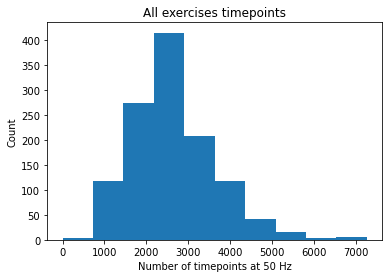

In [50]:
all_timepoint_data = list(global_counters["num_timepoints"].elements())
plt.hist(all_timepoint_data)
plt.title("All exercises timepoints")
plt.xlabel("Number of timepoints at 50 Hz")
plt.ylabel("Count")
plt.show()

In [51]:
for file, df in all_data.items():
    for key, stats in global_stats.items():
        if key in ["qx", "qy", "qz", "qw", "num_timepoints"]:
            continue
        df[key] = (df[key] - stats["mean"]) / stats["std"]

# Saving

In [52]:
for file, df in all_data.items():
    save_name = data_dir + file + "_full.csv"
    df.to_csv(save_name, index=False)